# **Product Recommendation System**

Goals:
Suggest top five products for the investment bracket, with detailed report sentiment analysis on those products reviews.



In [2]:
#import the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Step1: Importing Required packages and loading required dataset

In [5]:
import pandas as pd

import numpy as np

from sklearn.neighbors import NearestNeighbors

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.feature_selection import SelectKBest

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import re

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split

from sklearn import neighbors

import matplotlib.pyplot as plt

import matplotlib_inline

I have used 5-core Home and Kitchen reviews dataset. It is subset of the data in which all users and items have at least 5 reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [10]:
import json

path = '/content/drive/MyDrive/Capstone Project/Home_and_Kitchen_5.json'

prod = []

with open(path, 'r') as f:
    for line in f:
        prod.append(json.loads(line))


I would like to see the top five rows of dataset.

In [19]:
sys = pd.DataFrame(prod)

In [20]:
#partial top 5 views
sys.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


###Data Dict

The above dataset has 9 variables. Those are

reviewerID: ID of the reviewer

asin: ID of the product  

reviewerName: Name of the reviewer

helpful: helpfulness rating of the reviewer, e.g: 2/3

reviewText: text of the review

overall: rating of the product

summary: summary of the review

unixReviewTime: time of the review (unix time)

reviewTime: time of the review (raw)


In [22]:
#checking the shape of dataset
sys.shape

(551682, 9)

From the above we can say that the dataset has 551682 rows and 9 columns of information.

#### Step2: Preparing data for KNN modeling

In [23]:
sys.helpful.values.tolist()

[[0, 0],
 [0, 0],
 [26, 27],
 [14, 18],
 [0, 0],
 [0, 0],
 [2, 3],
 [32, 39],
 [13, 13],
 [0, 0],
 [3, 3],
 [0, 0],
 [0, 0],
 [1, 2],
 [16, 16],
 [1, 1],
 [0, 0],
 [1, 1],
 [0, 0],
 [0, 1],
 [0, 0],
 [4, 4],
 [0, 0],
 [1, 1],
 [0, 0],
 [2, 2],
 [2, 3],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [13, 14],
 [11, 11],
 [1, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 0],
 [0, 0],
 [2, 2],
 [62, 64],
 [0, 0],
 [1, 1],
 [0, 0],
 [5, 5],
 [0, 0],
 [0, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [2, 2],
 [0, 0],
 [2, 2],
 [0, 0],
 [0, 0],
 [2, 2],
 [4, 4],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 1],
 [1, 1],
 [1, 1],
 [2, 2],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [4, 4],
 [0, 0],
 [2, 2],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 1],
 [2, 2],
 [0, 1],
 [0, 0],
 [0, 0],
 [2, 2],
 [0, 0],
 [9, 11],
 [0, 0],
 [1, 1],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 0],
 [15, 15],
 [0, 0],
 [0, 0],
 [0, 1],


In [28]:
# Make new two columns out of 'helpful' column
sys[['helpfulfirst', 'helpfulsecond']] = pd.DataFrame(sys.helpful.values.tolist(), index=sys.index)

In [30]:
#checking the shape
sys.shape

(551682, 10)

I take the prodcuts with more than 100 product reviews for further analysis and modeling.

In [33]:
reviews_count = sys.groupby('asin').count().reset_index()


In [36]:
#checking the partial top view
reviews_count.head().T

,0,1,2,3,4
asin,0615391206,0689027818,0912696591,1223070743,1567120709
reviewerID,11,5,93,8,16
reviewerName,11,5,93,8,16
reviewText,11,5,93,8,16
overall,11,5,93,8,16
summary,11,5,93,8,16
unixReviewTime,11,5,93,8,16
reviewTime,11,5,93,8,16
helpfulfirst,11,5,93,8,16
helpfulsecond,11,5,93,8,16


In [66]:
# merge the column of sys and reviews_count
sys_merged = pd.merge(sys, reviews_count, on = 'asin', how = 'right')


In [67]:
#renaming the columns
sys_merged.rename(columns={'reviewerID_y':'reviews_count','overall_x':'overall_review','summary_x':'summary_review'},inplace=True)

In [68]:
#merge the final columns
sys_final = sys_merged[['asin', 'summary_review', 'overall_review', 'reviews_count']]


In [69]:
#The code will sort the reviews by the number of reviews, and then return a list of all reviews with the highest count.
sys_merged=sys_merged.sort_values(by=['reviews_count'],ascending=False)

In [77]:
# selecting products with more than 50 reviews
sys_count = sys_merged[sys_merged.reviews_count > 50]

In [86]:
# The code will generate a DataFrame with the mean rating for each asin
sys_review_mean = sys_count.groupby('asin')['overall_review'].mean().reset_index()

In [80]:
sys_count.head()

,reviewerID_x,asin,reviewerName_x,reviewText_x,overall_review,summary_review,unixReviewTime_x,reviewTime_x,helpfulfirst_x,helpfulsecond_x,reviews_count,reviewerName_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,helpfulfirst_y,helpfulsecond_y
42042,A1KB2Z9BE3BSI,B00006JSUA,Adam,I got this for the hype of searing steaks and ...,5.0,Great for someone new to cast iron,1390435200,"01 23, 2014",0,0,1064,1064,1064,1064,1064,1064,1064,1064,1064
43074,A3ROWXDK7R0WKS,B00006JSUA,Will H,I use this skillet for cooking bacon and most ...,5.0,Best $10 ever spent,1402099200,"06 7, 2014",0,0,1064,1064,1064,1064,1064,1064,1064,1064,1064
43073,AOGU17DLH0A4M,B00006JSUA,will,Handy smaller cast iron pan for the oven...Gre...,5.0,Add This Pan To Your Cooking Tool....,1383696000,"11 6, 2013",0,0,1064,1064,1064,1064,1064,1064,1064,1064,1064
43072,AN1N8AMFA3K34,B00006JSUA,wifemeetslife,I have purchased several Lodge Products. This ...,5.0,The Busiest Pan in my Kitchen,1345766400,"08 24, 2012",1,2,1064,1064,1064,1064,1064,1064,1064,1064,1064
43099,A9E9CW0ZEI160,B00006JSUA,Zorazen,I use this skillet every week. I expect I'll c...,5.0,Everything I could ask for.,1382486400,"10 23, 2013",0,0,1064,1064,1064,1064,1064,1064,1064,1064,1064


In [81]:
#The code attempts to create a DataFrame of all the reviews for each product.
sys_summary_review = pd.DataFrame(sys_count.groupby('asin')['summary_review'].apply(list).reset_index())

In [87]:
#merge the reviews
sys_model = pd.merge(sys_summary_review, sys_review_mean, on = 'asin', how = 'inner')


In [91]:
sys_model_data = sys_model[['asin', 'summary_review', 'overall_review']]


In [92]:
#checking the partial view
sys_model_data.head(5)

,asin,summary_review,overall_review
0,0912696591,"[simple book but tons of info, Nice Book, Need...",4.548387
1,B00000JGRP,"[Great Little Tool!, Not made to the same stan...",3.948052
2,B00000JGRT,"[milk-based products OK, but doesn't work for ...",4.473934
3,B00002N5Z9,"[Fits perfect, and energy efficient., Ability ...",4.176471
4,B00002N602,"[Couldn't live without this, Save Gas and Elec...",4.563107


##### Text processing for modeling:

In [97]:
#define a text process as text as input parameter
def text_process(text):
  text = text.lower()
  text = re.sub('[^a-z]+', ' ', text).strip()
  return text



The code will create a new column in the dataframe called clean_summary_review that is a string of all the text in df_model_data['summary_review'] with any single word or sentence replaced by an underscore.

In [98]:
sys_model_data['clean_summary_review'] = sys_model_data['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)


In [100]:
#checking the partial view
sys_model_data['clean_summary_review'].head(5)

,clean_summary_review
0,simple book but tons of info nice book needed ...
1,great little tool not made to the same standar...
2,milk based products ok but doesn t work for so...
3,fits perfect and energy efficient ability to m...
4,couldn t live without this save gas and electr...


In [102]:
#The code will drop all duplicates of the overall category.
sys_model_data.drop_duplicates(['overall_review'],keep = 'last', inplace=True)

In [104]:
#The code simply resets the index of the dataframe.
sys_model_data = sys_model_data.reset_index()


#### TFIDF model feature extraction from clean_summary_review column:

In [108]:
#TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features = 500)
#The code will create a new dataframe with the tfidf values for each review.
X = tfidf.fit_transform(sys_model_data['clean_summary_review'])

Splitting X into train and test datasets.

In [110]:
#The code creates a DataFrame with the data that is stored in X_reviews.
X_reviews = pd.DataFrame(X.toarray(), columns = tfidf.get_feature_names_out()).astype(int)

In [117]:
X_reviews.head()

,absolutely,accurate,actually,addition,advertised,affordable,air,alternative,amazing,amazon,appliance,attractive,away,awesome,bad,bag,bags,baking,basic,beautiful,bed,best,best coffee,better,better expected,beware,big,bit,black,blender,board,bottle,bought,bowl,bowls,box,bread,brita,broke,broken,...,vac,vacuum,value,ve,ve owned,versatile,waffle,waffles,want,wanted,warm,waste,waste money,water,way,weight,white,wife,wine,wish,won,wonderful,work,work great,worked,working,works,works advertised,works fine,works good,works great,works like,works perfectly,worth,worth money,wow,wrong,year,years,yes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
#The code will create a list of reviews and then convert it into an array.
X_reviews_array= np.array(X_reviews)

In [112]:
split_percent = 0.8

#The code is used to calculate the percentage of reviews that are positive and negative.
split_size = np.floor(split_percent * X_reviews_array.shape[0]).astype(int)

In [119]:
print(split_size)

1255


In [113]:
#split the dataset
X_train = X_reviews_array[:split_size]

X_test = X_reviews_array[split_size:]


#### Predictive Modeling: Let's use KNerighborsClassifier to classify: Predicting overall review based on product reviews:

Let's define the target variable for predictive modeling

The code starts by creating a list of the overall data.This is done with sys_model_data['overall'].Then, it creates two variables: X_train and y_train.These are lists of all the training data for this model.The first variable, X_train, has shape[0] equal to 10 because there are 10 rows in that list.The second variable, y_test, has shape[0]: 9 because there are 9 columns in that list.Next, it creates an array called xy which contains all the features from both arrays (X and Y).

In [116]:
y_train = sys_model_data['overall_review'][:X_train.shape[0]].astype(int)

y_test = sys_model_data['overall_review'][X_train.shape[0]:].astype(int)


In [120]:
knnclassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')

#The code creates a model that predicts the probability of an event occurring.
knnclassifier.fit(X_train, y_train)
#predict the results
knnclassifier_predictions= knnclassifier.predict(X_test)

In [123]:
# the accucary score and mean squared error
print('Accuracy score: ', accuracy_score(y_test, knnclassifier_predictions))

print('Mean squared error: ', mean_squared_error(y_test, knnclassifier_predictions))

Accuracy score:  0.8949044585987261
Mean squared error:  0.10509554140127389


#### Word Clouding for each review group:

In [124]:
#he code will create a list of all the reviews for each overall rating.
review_text_for_overall = sys_model_data.groupby('overall_review')['summary_review'].apply(list).reset_index()

In [127]:
#print top 5 view
review_text_for_overall

,overall_review,summary_review
0,2.839286,"[[You get what you pay for, It works okay., Di..."
1,2.942029,"[[High maintenance, but makes great coffee, Mi..."
2,2.988095,"[[Frayed after 1 wash, Purchasing linens witho..."
3,3.016667,"[[Really efficient little grinder, Best coffee..."
4,3.030612,"[[Works...By Trial And Error, Nice for breakfa..."
...,...,...
1564,4.934426,"[[I love these, Love these, Keep Your Wine Dif..."
1565,4.952381,"[[Found it!, Trimumph of Design, Works great!,..."
1566,4.972603,"[[Love it! The best!, Love that BMI is include..."
1567,4.983051,"[[creative & easy to use, Love these labels!!!..."


 The code starts by creating a list of review text objects.
 It then creates an empty string and appends the summary to it, which is done with the .join() method.
 The code then uses the text_process function to process each word in this string, which is done with the lambda x: text_process(x) function.
 The code takes the text of the review and converts it into a list of words, which are then joined together.

In [132]:
review_text_for_overall['clean_summary'] = review_text_for_overall['summary_review'].apply(
    lambda review_list: ' '.join([str(item) for item in review_list])
).apply(lambda x: text_process(x))

In [133]:
review_text_for_overall

,overall_review,summary_review,clean_summary
0,2.839286,"[[You get what you pay for, It works okay., Di...",you get what you pay for it works okay disappo...
1,2.942029,"[[High maintenance, but makes great coffee, Mi...",high maintenance but makes great coffee mixed ...
2,2.988095,"[[Frayed after 1 wash, Purchasing linens witho...",frayed after wash purchasing linens without to...
3,3.016667,"[[Really efficient little grinder, Best coffee...",really efficient little grinder best coffee gr...
4,3.030612,"[[Works...By Trial And Error, Nice for breakfa...",works by trial and error nice for breakfast ok...
...,...,...,...
1564,4.934426,"[[I love these, Love these, Keep Your Wine Dif...",i love these love these keep your wine differe...
1565,4.952381,"[[Found it!, Trimumph of Design, Works great!,...",found it trimumph of design works great stunni...
1566,4.972603,"[[Love it! The best!, Love that BMI is include...",love it the best love that bmi is included gre...
1567,4.983051,"[[creative & easy to use, Love these labels!!!...",creative easy to use love these labels amazing...


##### Write a function to draw wordcloud for each overall rating group:

In [141]:
#set the stop words
stop_words = set(STOPWORDS)


def wordcloud_plot(txt_dat, title=None):
    wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=300, max_font_size=30,scale=3, random_state=1).generate(str(txt_dat))



    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)


    plt.imshow(wordcloud)
    plt.show()

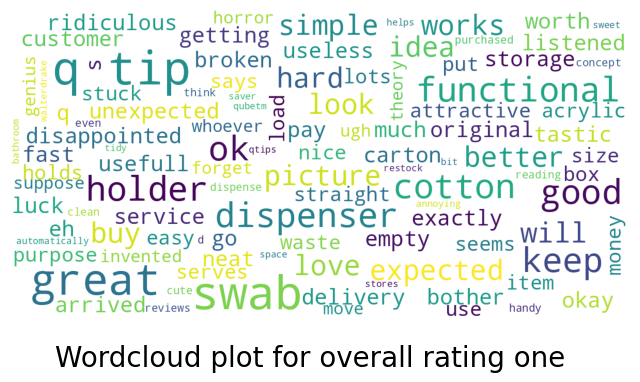

In [140]:
#the graph of one rating
wordcloud_plot(review_text_for_overall['clean_summary'][0], title = 'Wordcloud plot for overall rating one')


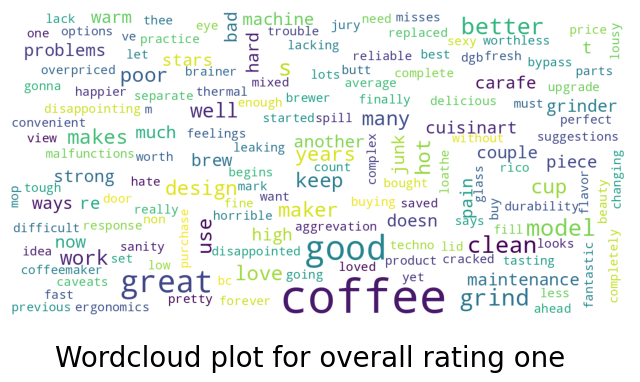

In [143]:
#the graph of two rating


wordcloud_plot(review_text_for_overall['clean_summary'][1], title = 'Wordcloud plot for overall rating one')

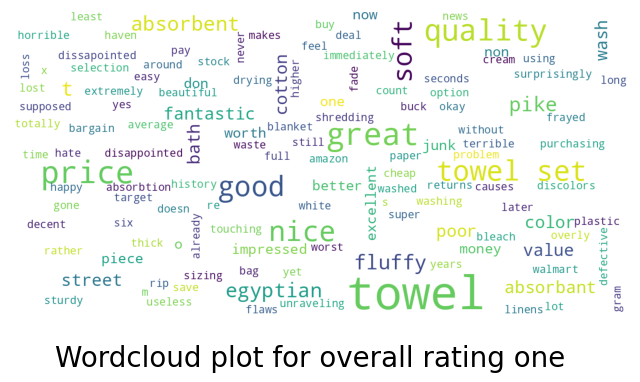

In [144]:
#the graph of three rating

wordcloud_plot(review_text_for_overall['clean_summary'][2], title = 'Wordcloud plot for overall rating one')

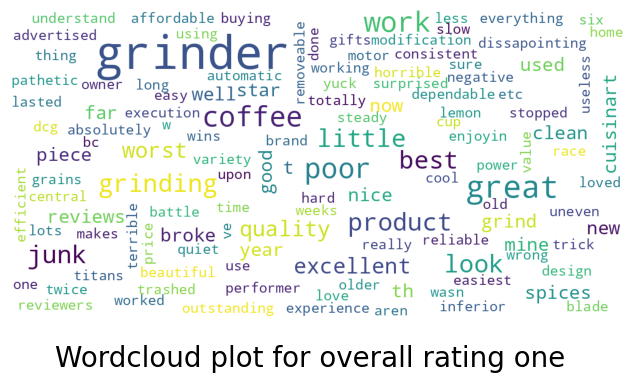

In [145]:
#plot the graph of four rating

wordcloud_plot(review_text_for_overall['clean_summary'][3], title = 'Wordcloud plot for overall rating one')

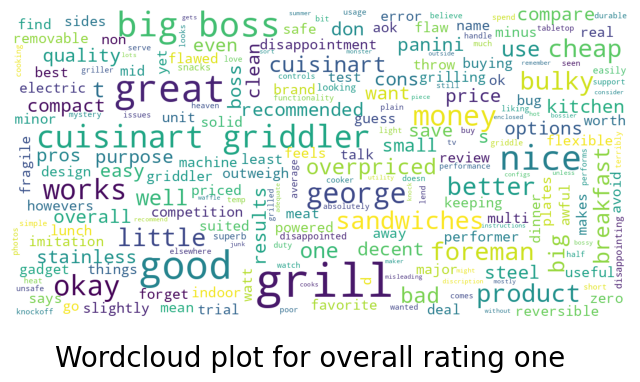

In [149]:
#the graph of five rating

wordcloud_plot(review_text_for_overall['clean_summary'][4], title = 'Wordcloud plot for overall rating one')

#### Applying KNN model to find out five nearest prodcuts:

To find the 5 nearest neighbors, I am going to use NearestNeighbors algorithm.

In [150]:
#The code is used to calculate the nearest neighbors of a given point in a dataset.
#with n=5 and algorithm ball_tree and fit the model
nearest_neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_train)

In [152]:
#The code will find the index of the nearest neighbor to X_train.
dist, indices = nearest_neighbors.kneighbors(X_train)

We have predicted the 5 products based on ratings by using KNN

In [159]:
for i in range(X_test.shape[0]):
    try:
        # Get the nearest neighbors for the i-th test product
        test_neighbors = nearest_neighbors.kneighbors([X_test[i]])
        related_product_indices = indices[i]  # assuming 'indices' is already from kneighbors()

        # Extract top 5 nearest neighbor indices
        first_nearest_product = related_product_indices[0]
        second_nearest_product = related_product_indices[1]
        third_nearest_product = related_product_indices[2]
        fourth_nearest_product = related_product_indices[3]
        fifth_nearest_product = related_product_indices[4]

        if i < 4:
            # Print the original product's review info
            print('Based on product reviews of', sys_model_data['asin'][X_train.shape[0] + i],
                  'the average rating is', sys_model_data['overall_review'][X_train.shape[0] + i])

            # Print recommended products
            print('The 1st recommended product is', sys_model_data['asin'][first_nearest_product],
                  'the average rating is', sys_model_data['overall_review'][first_nearest_product])
            print('The 2nd recommended product is', sys_model_data['asin'][second_nearest_product],
                  'the average rating is', sys_model_data['overall_review'][second_nearest_product])
            print('The 3rd recommended product is', sys_model_data['asin'][third_nearest_product],
                  'the average rating is', sys_model_data['overall_review'][third_nearest_product])
            print('The 4th recommended product is', sys_model_data['asin'][fourth_nearest_product],
                  'the average rating is', sys_model_data['overall_review'][fourth_nearest_product])
            print('The 5th recommended product is', sys_model_data['asin'][fifth_nearest_product],
                  'the average rating is', sys_model_data['overall_review'][fifth_nearest_product])
            print('-------------------------------------------------------------------------------------------')

    except Exception as e:
        print(f"Error processing index {i}: {e}")


Based on product reviews of B005SI8YZC the average rating is 3.8656716417910446
The 1st recommended product is 0912696591 the average rating is 4.548387096774194
The 2nd recommended product is B00002N8CX the average rating is 4.28476821192053
The 3rd recommended product is B00002N602 the average rating is 4.563106796116505
The 4th recommended product is B00000JGRP the average rating is 3.948051948051948
The 5th recommended product is B00004OCO6 the average rating is 4.43956043956044
-------------------------------------------------------------------------------------------
Based on product reviews of B005SPEV66 the average rating is 4.322033898305085
The 1st recommended product is 0912696591 the average rating is 4.548387096774194
The 2nd recommended product is B00002N8CX the average rating is 4.28476821192053
The 3rd recommended product is B00002N602 the average rating is 4.563106796116505
The 4th recommended product is B00000JGRP the average rating is 3.948051948051948
The 5th recomm

#Conclusion:

1. Building an item-based collaborative filtering system based on K - nearest neighbors to find the  most similar products. I used Amazon Home and Kitchen reviews dataset. Also, build K neighbors classifier model to predict overall review rating based on text reviews.

2. Analyzing the performance metrics of the above recommender system

##Summary

Within this e-commerce data science project.

1. we have come up with KNN product recommendater system for customers based on their purchase history and product reviews (Amazon's home and kitchen dataset)

2. we also performed sentiment analysis on any given product for a given customer (Amazon's home and kitchen dataset)